In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor

In [86]:
def fill_data(df, xx):
    ds = pd.DataFrame([])
    ds.index = pd.date_range(start='1960-10-03', end='2023-12-06', freq='D')

    for year in np.arange(1960, 2024):
        year_mask = ds[ds.index.year == year]
        ds.loc[year_mask.index, 'discharge'] = xx.to_numpy()[:year_mask.shape[0]]

    index = ds.index.isin(df_discharge.index)
    ds.loc[index, 'discharge'] = df
    return ds

In [87]:
# Step 1: Load the precipitation data
file_path = 'ncei_Tacoma-Airport.csv'
df_precip = pd.read_csv(file_path)

# Step 2: Convert 'DATE' to datetime format
df_precip['DATE'] = pd.to_datetime(df_precip['DATE'])

# Step 3: Identify gaps (missing PRCP values)
df_precip['gap'] = df_precip['PRCP'].isna()

# Step 4: Apply KNN imputation to fill missing values
df_precip['DATE_ordinal'] = df_precip['DATE'].apply(lambda date: date.toordinal())
imputer = KNNImputer(n_neighbors=2)

# Impute the missing values
df_precip[['DATE_ordinal', 'PRCP_filled_knn']] = imputer.fit_transform(df_precip[['DATE_ordinal', 'PRCP']])

# Step 5: Print the specific rows where KNN filled missing values
filled_rows = df_precip[df_precip['gap'] == True][['DATE', 'PRCP_filled_knn']]

df_precip

,STATION,NAME,DATE,AWND,FMTM,FRGT,PGTM,PRCP,SNOW,SNWD,...,WDFM,WESD,WSF1,WSF2,WSF5,WSFG,WSFM,gap,DATE_ordinal,PRCP_filled_knn
0,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-01,NaN,NaN,NaN,NaN,0.47,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711127.0,0.47
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-02,NaN,NaN,NaN,NaN,0.59,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711128.0,0.59
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-03,NaN,NaN,NaN,NaN,0.42,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711129.0,0.42
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-04,NaN,NaN,NaN,NaN,0.31,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711130.0,0.31
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1948-01-05,NaN,NaN,NaN,NaN,0.17,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,711131.0,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2023-12-27,12.75,NaN,NaN,NaN,0.10,0.0,0.0,...,NaN,NaN,NaN,23.9,34.0,NaN,NaN,False,738881.0,0.10
27755,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2023-12-28,10.51,NaN,NaN,NaN,0.06,0.0,0.0,...,NaN,NaN,NaN,19.9,27.1,NaN,NaN,False,738882.0,0.06
27756,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2023-12-29,12.53,NaN,NaN,NaN,0.00,0.0,0.0,...,NaN,NaN,NaN,28.0,40.9,NaN,NaN,False,738883.0,0.00
27757,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2023-12-30,5.59,NaN,NaN,NaN,0.10,0.0,0.0,...,NaN,NaN,NaN,13.0,18.1,NaN,NaN,False,738884.0,0.10


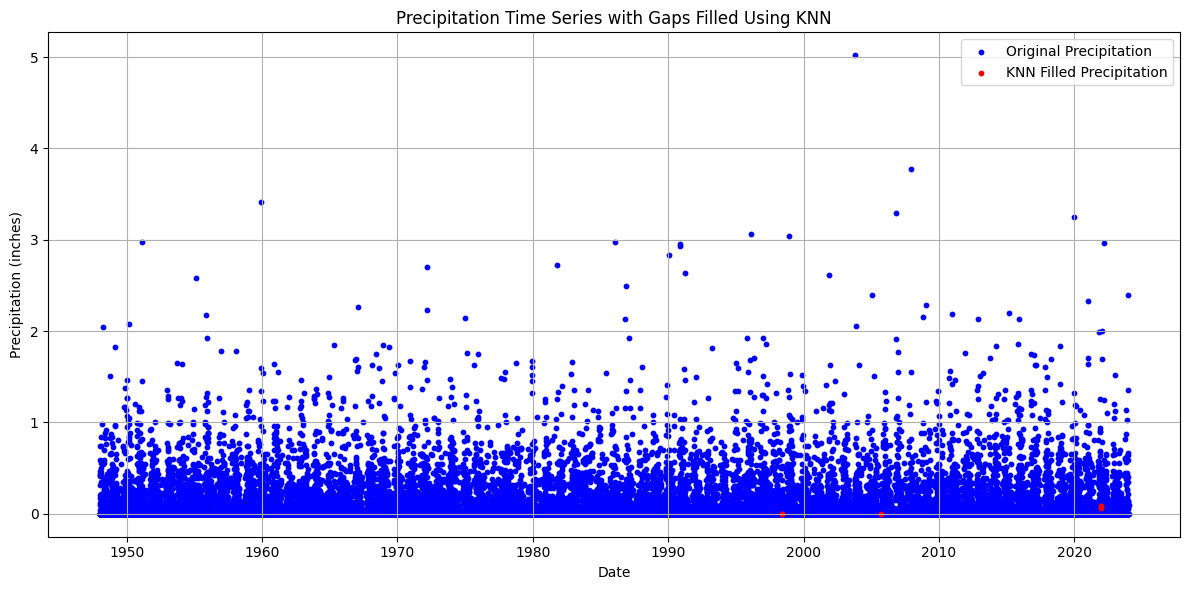

In [88]:
# Step 6: Plot the original and KNN-filled precipitation values
plt.figure(figsize=(12, 6))

# Original values in blue
plt.scatter(df_precip['DATE'], df_precip['PRCP'], color='blue', label='Original Precipitation', s=10)

# Highlight KNN-filled values in red
plt.scatter(filled_rows['DATE'], filled_rows['PRCP_filled_knn'], color='red', label='KNN Filled Precipitation', s=10)

# Titles and labels
plt.title('Precipitation Time Series with Gaps Filled Using KNN')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

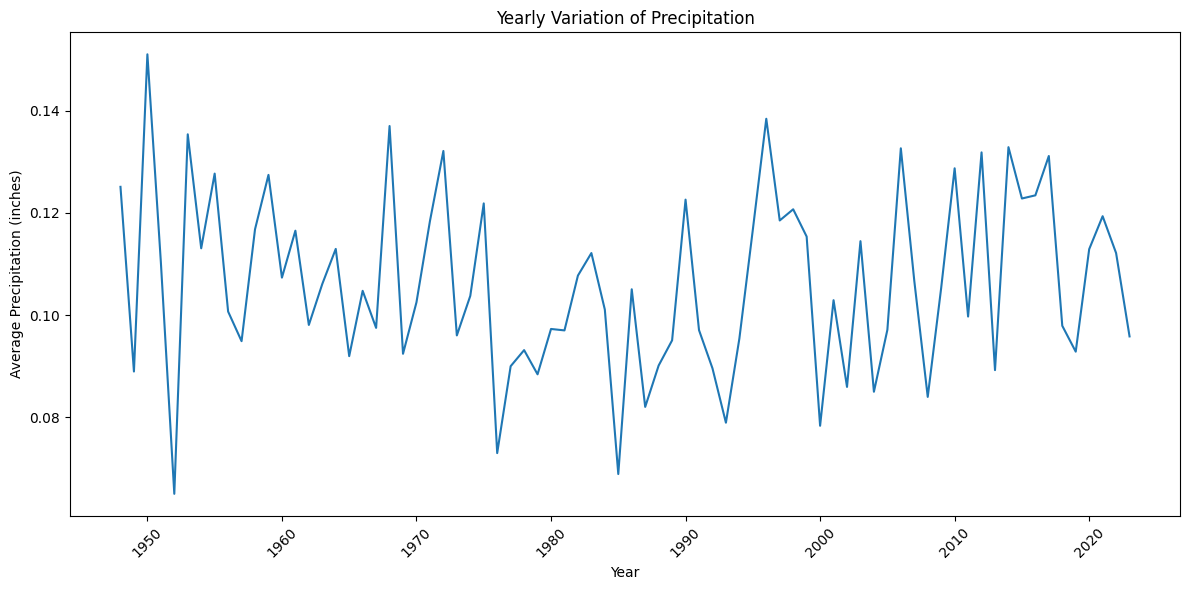

<ipython-input-89-1caaa2903c22>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Month', y='PRCP_filled_knn', data=df_precip, palette='Set1', order=range(1, 13))


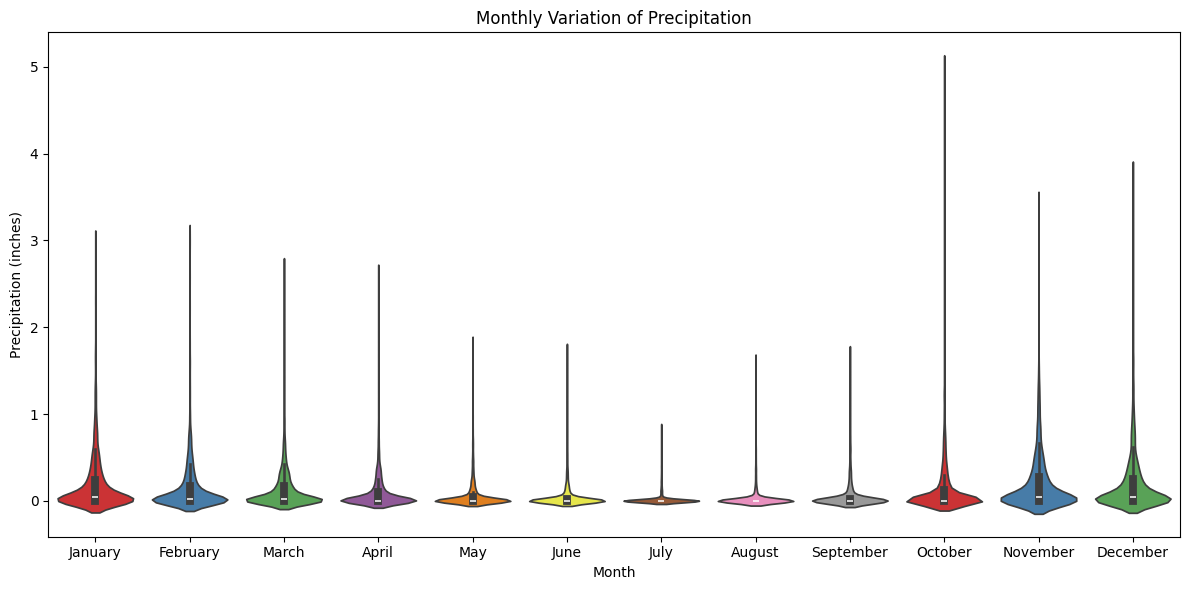

In [89]:
# prompt: plot the yearly variation and monthly violin plot with months name and different colours of the above precipitation data
import seaborn as sns
# Extract year and month from the DATE column
df_precip['Year'] = df_precip['DATE'].dt.year
df_precip['Month'] = df_precip['DATE'].dt.month

# Yearly variation
plt.figure(figsize=(12, 6))
df_precip.groupby('Year')['PRCP_filled_knn'].mean().plot(kind='line')
plt.title('Yearly Variation of Precipitation')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly violin plot
plt.figure(figsize=(12, 6))
import calendar
month_names = [calendar.month_name[i] for i in range(1, 13)]
sns.violinplot(x='Month', y='PRCP_filled_knn', data=df_precip, palette='Set1', order=range(1, 13))
plt.title('Monthly Variation of Precipitation')
plt.xlabel('Month')
plt.ylabel('Precipitation (inches)')
plt.xticks(ticks=range(12), labels=month_names)
plt.tight_layout()
plt.show()


In [90]:
file_path= '12105900_Discharge_1960_2023_Daily.txt'
# Reload the file with proper column names and check the data
df_discharge = pd.read_csv(file_path, sep='\t', comment='#', skiprows=31)
df_discharge.columns = ['agency_cd', 'site_no', 'datetime', 'discharge_cfs', 'status']

# Convert the datetime column to pandas datetime type
df_discharge['datetime'] = pd.to_datetime(df_discharge['datetime'], errors='coerce')

# Drop rows with invalid datetime
#df_discharge = df_discharge.dropna(subset=['datetime'])

In [91]:
df_discharge.index = df_discharge['datetime']
df1 = df_discharge['discharge_cfs']

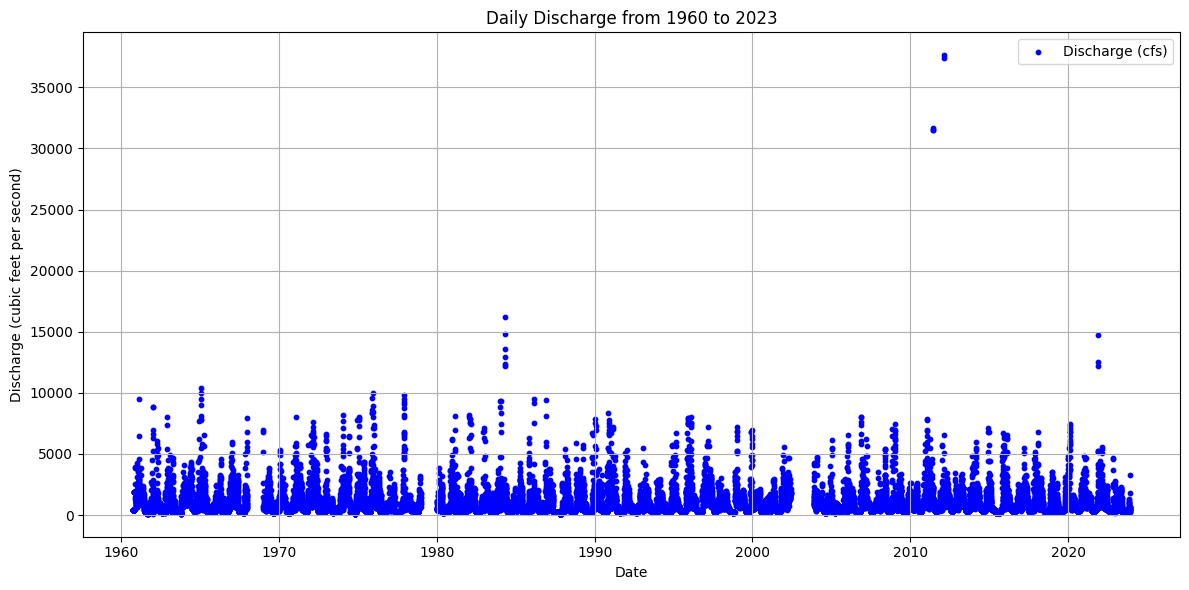

In [92]:
# Create a scatter plot for the discharge data over time
plt.figure(figsize=(12, 6))
plt.scatter(df1.index, df1, color='blue', s=10, label='Discharge (cfs)')
plt.title('Daily Discharge from 1960 to 2023')
plt.xlabel('Date')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

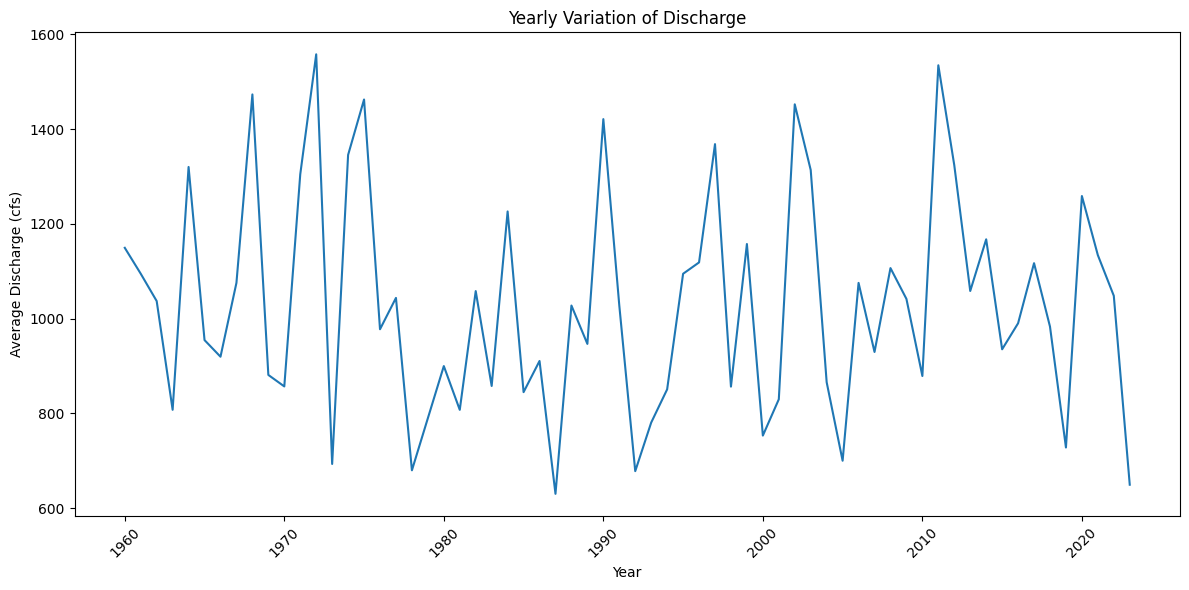

<ipython-input-93-b80767c4023f>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Month', y='discharge_cfs', data=df_discharge, palette='Set1', order=range(1, 13))


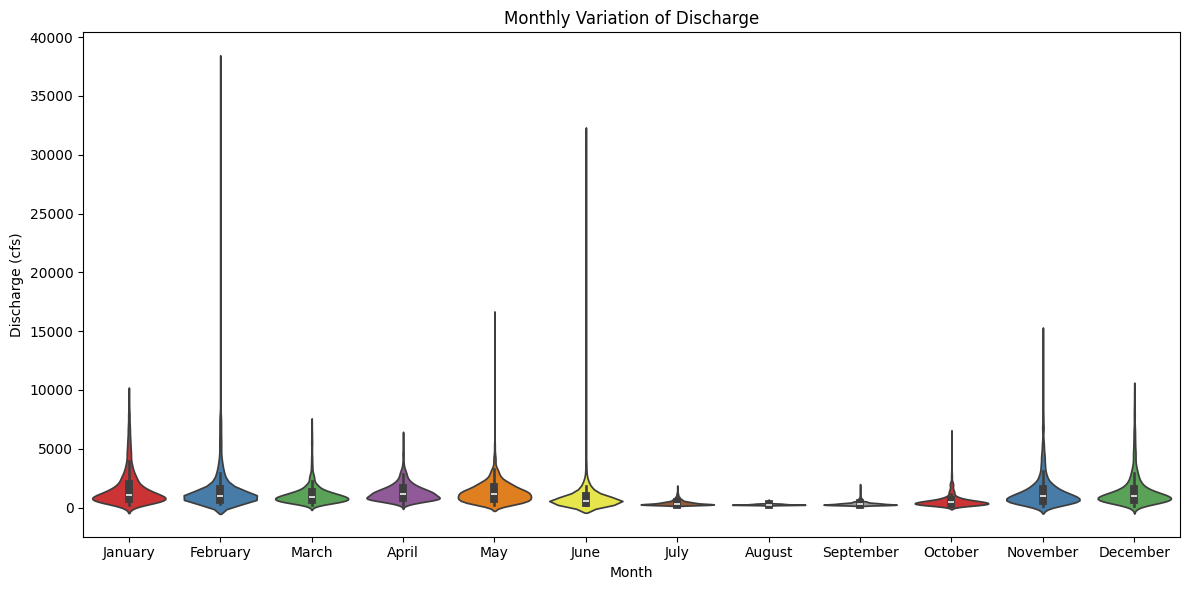

In [93]:
# prompt: plot the yearly variation and monthly violin plot with months name and different colours of the above discharge  data

df_discharge['Year'] = df_discharge['datetime'].dt.year
df_discharge['Month'] = df_discharge['datetime'].dt.month

# Yearly variation
plt.figure(figsize=(12, 6))
df_discharge.groupby('Year')['discharge_cfs'].mean().plot(kind='line')
plt.title('Yearly Variation of Discharge')
plt.xlabel('Year')
plt.ylabel('Average Discharge (cfs)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly violin plot
plt.figure(figsize=(12, 6))
month_names = [calendar.month_name[i] for i in range(1, 13)]
sns.violinplot(x='Month', y='discharge_cfs', data=df_discharge, palette='Set1', order=range(1, 13))
plt.title('Monthly Variation of Discharge')
plt.xlabel('Month')
plt.ylabel('Discharge (cfs)')
plt.xticks(ticks=range(12), labels=month_names)
plt.tight_layout()
plt.show()


In [94]:
xx = df1.groupby(df1.index.dayofyear).mean()



In [95]:
ds1 = fill_data(df1, xx)

gaps = ds1[~ds1.index.isin(df1.index)].index
nogaps = ds1[ds1.index.isin(df1.index)].index
nogaps

DatetimeIndex(['1960-10-03', '1960-10-04', '1960-10-05', '1960-10-06',
               '1960-10-07', '1960-10-08', '1960-10-09', '1960-10-10',
               '1960-10-11', '1960-10-12',
               ...
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06'],
              dtype='datetime64[ns]', length=21814, freq=None)

In [96]:
df_precip.index = df_precip['DATE']

df_rf = ds1.copy(deep=True)
df_rf['prcp'] = df_precip.PRCP_filled_knn
df_rf['time'] = np.arange(len(df_rf))

In [97]:
train_data = df_rf.loc[nogaps, ['time', 'discharge', 'prcp']]
test_data = df_rf.loc[gaps, ['time', 'prcp']]

X_train = train_data[['time', 'prcp']]  # Time feature
y_train = train_data['discharge']  # Known discharge values

rf_model = RandomForestRegressor(n_estimators=50,min_samples_leaf=2,min_samples_split=2,max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)


if len(test_data) > 0:
    predicted_values = rf_model.predict(test_data[['time', 'prcp']])
    df_rf.loc[gaps, 'discharge'] = predicted_values

In [98]:
dsx = ds1.copy(deep=True)
ds1['day'] = np.arange(ds1.discharge.shape[0])

ds2 = ds1.loc[nogaps,:]
ds2.index = ds2.day
train_data = ds2['discharge']

ds4 = ds1.loc[gaps,:]
ds4.index = ds4.day
missing = ds4['discharge']
missing

,discharge
day,
2649,1548.283333
2650,1617.366667
2651,1584.116667
2652,1546.500000
2653,1808.050000
...,...
15742,1320.316667
15743,1340.450000
15744,1232.883333


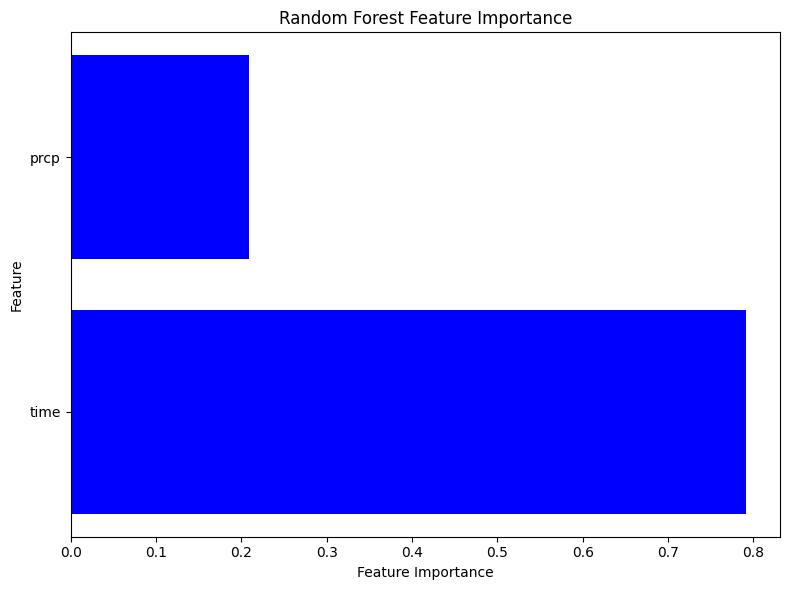

In [99]:
# Assuming that RandomForestRegressor has been trained as 'best_rf_model'
importances = rf_model.feature_importances_  # Get feature importances from the model
feature_names = X_train.columns  # Feature names: 'time' and 'prcp'

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


 97%|=================== | 21237/21814 [00:37<00:01]       

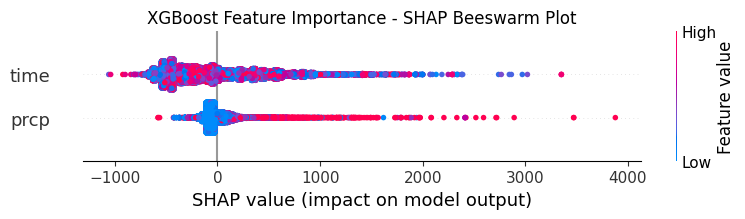

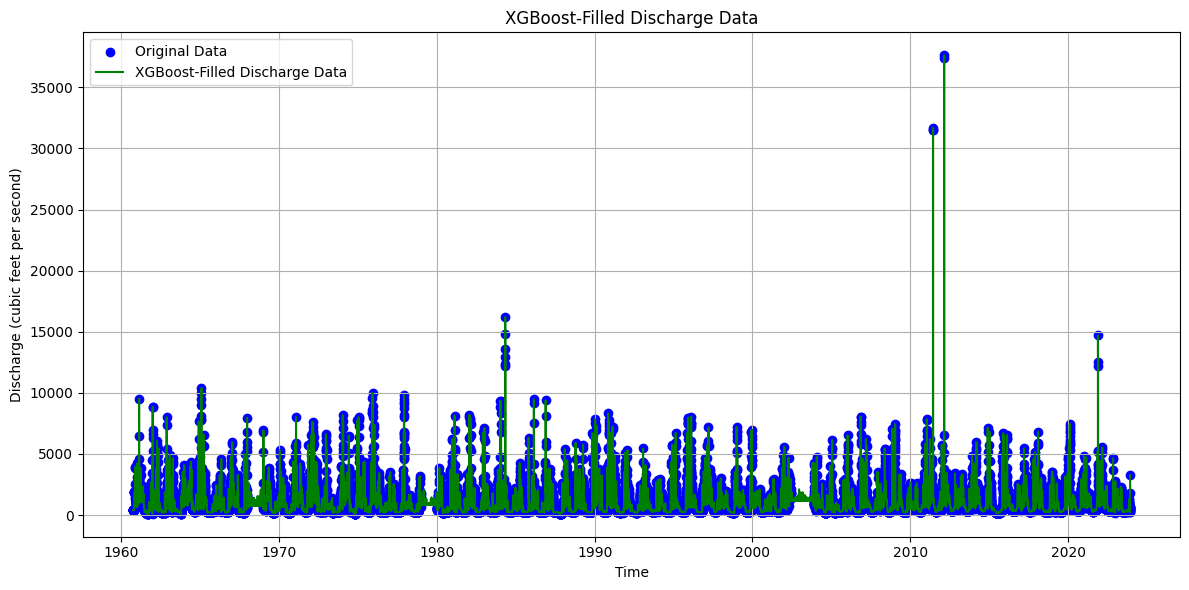

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Step 1: Prepare the data (same preprocessing as RF model)
df_xgb = ds1.copy(deep=True)  # Copy of the data
df_xgb['prcp'] = df_precip.PRCP_filled_knn  # Precipitation filled with KNN
df_xgb['time'] = np.arange(len(df_xgb))  # Time feature

# Train data
train_data = df_xgb.loc[nogaps, ['time', 'discharge', 'prcp']]
test_data = df_xgb.loc[gaps, ['time', 'prcp']]

X_train = train_data[['time', 'prcp']]  # Features for training
y_train = train_data['discharge']  # Target variable

# Step 2: Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 3: Predict missing values
if len(test_data) > 0:
    predicted_values = xgb_model.predict(test_data[['time', 'prcp']])
    df_xgb.loc[gaps, 'discharge'] = predicted_values

# Step 4: Feature importance using SHAP and beeswarm plot
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

# Plot the SHAP values (beeswarm plot for feature importance)
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, show=False)
plt.title('XGBoost Feature Importance - SHAP Beeswarm Plot')
plt.tight_layout()
plt.show()

# Optional: Visualize the final result
plt.figure(figsize=(12, 6))
plt.scatter(nogaps, df1.loc[nogaps], color='b', label='Original Data')
plt.plot(df_xgb.index, df_xgb['discharge'], color='g', label='XGBoost-Filled Discharge Data')
plt.title('XGBoost-Filled Discharge Data')
plt.xlabel('Time')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Tuning Arima
#auto_model = pm.auto_arima(train_data,
#                           start_p=1, start_q=1,
#                           max_p=5, max_q=5,
#                           d=None,  # Let auto_arima choose differencing
#                           seasonal=True,  # Set to True for seasonal data
#                           stepwise=True,
#                           trace=True)

#print(f"Best ARIMA order: {auto_model.order}")

In [121]:
#train_data = ds1.loc[nogaps]
model = ARIMA(train_data['discharge'], order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


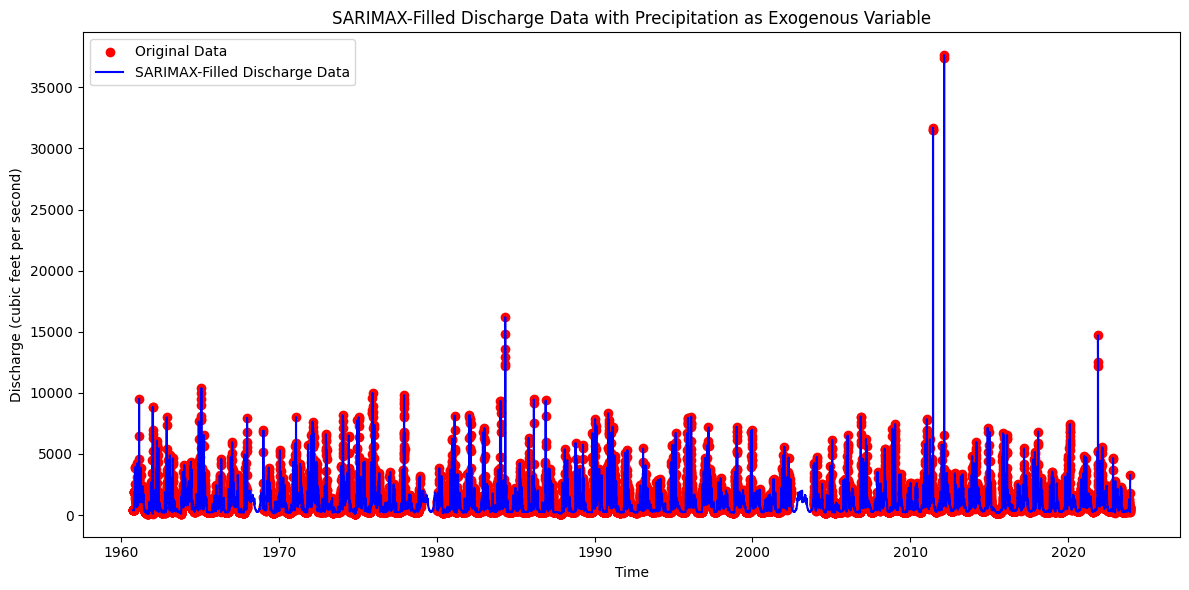

In [127]:
# prompt: like the airma plot the sarimax using preceptor as factor

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming 'df_precip' contains the precipitation data with 'PRCP_filled_knn' column
# and 'ds1' contains the discharge data with 'discharge' column

# Prepare the data for SARIMAX
df_sarimax = ds1.copy(deep=True)
df_sarimax['prcp'] = df_precip.PRCP_filled_knn
df_sarimax['time'] = np.arange(len(df_sarimax))

# Train data
train_data = df_sarimax.loc[nogaps, ['time', 'discharge', 'prcp']]
test_data = df_sarimax.loc[gaps, ['time', 'prcp']]

# Define the SARIMAX model with precipitation as an exogenous variable
model = SARIMAX(train_data['discharge'], exog=train_data['prcp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Fit the model
model_fit = model.fit()

# Make predictions
if len(test_data) > 0:
    predictions = model_fit.get_forecast(steps=len(test_data), exog=test_data['prcp'])
    predicted_values = predictions.predicted_mean

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(nogaps, df1.loc[nogaps], color='r', label='Original Data')
plt.plot(df_sarimax.index, df_sarimax['discharge'], color='b', label='SARIMAX-Filled Discharge Data')
plt.title('SARIMAX-Filled Discharge Data with Precipitation as Exogenous Variable')
plt.xlabel('Time')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()


In [122]:
predicted_values = model_fit.predict(start=missing.index[0], end=missing.index[-1])

dsx.iloc[missing]['discharge'] = predicted_values

<ipython-input-122-d98c96887a15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsx.iloc[missing]['discharge'] = predicted_values


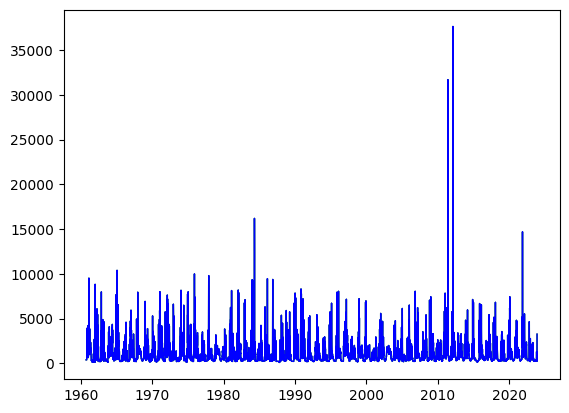

In [123]:
plt.plot(dsx.index, dsx['discharge'], color='g', label='ARIMA', lw=1)
plt.plot(ds1.index, ds1.discharge, color='b', label='climatology', lw=1)

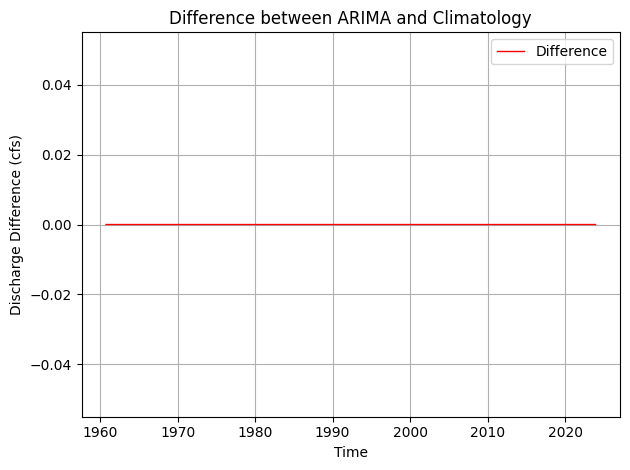

In [124]:
# prompt: plot the difference between arima and climatology above

plt.plot(dsx.index, dsx['discharge'] - ds1.discharge, color='r', label='Difference', lw=1)
plt.title('Difference between ARIMA and Climatology')
plt.xlabel('Time')
plt.ylabel('Discharge Difference (cfs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


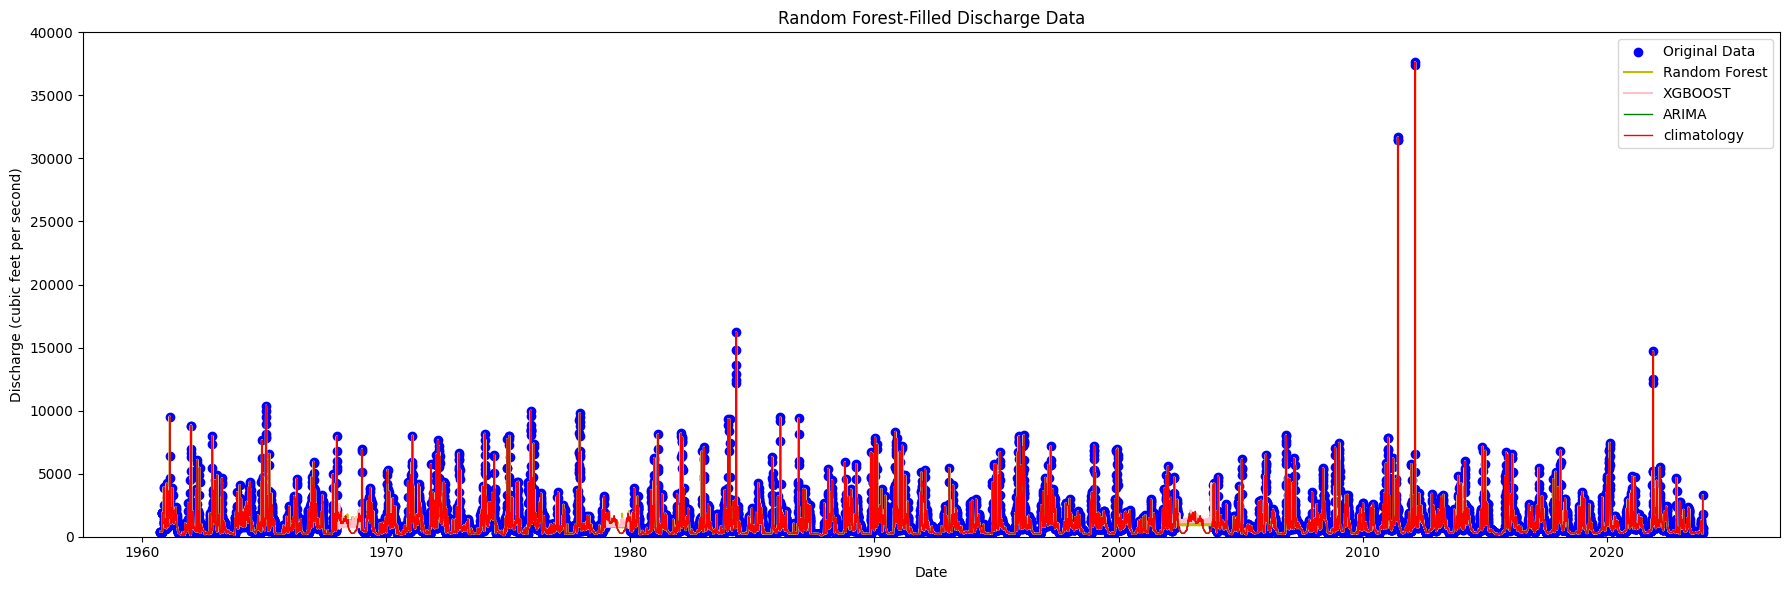

In [113]:
# Step 6: Visualize the result
plt.figure(figsize=(18, 6))

# Plot the original data (before filling gaps)
plt.scatter(nogaps, df1.loc[nogaps], color='b', label='Original Data')
plt.plot(df_rf.index, df_rf['discharge'], color='y', label='Random Forest')
plt.plot(df_xgb.index,df_xgb['discharge'],color='pink',label='XGBOOST')
plt.plot(dsx.index, dsx['discharge'], color='g', label='ARIMA', lw=1)
plt.plot(ds1.index, ds1.discharge, color='r', label='climatology', lw=1)

# Plot settings
plt.title('Random Forest-Filled Discharge Data')
plt.xlabel('Date')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
#plt.xlim(pd.to_datetime('2002-01-03'), pd.to_datetime('2004-01-06'))
plt.ylim(0, 40000)
#plt.grid(True)
plt.tight_layout()
plt.show()

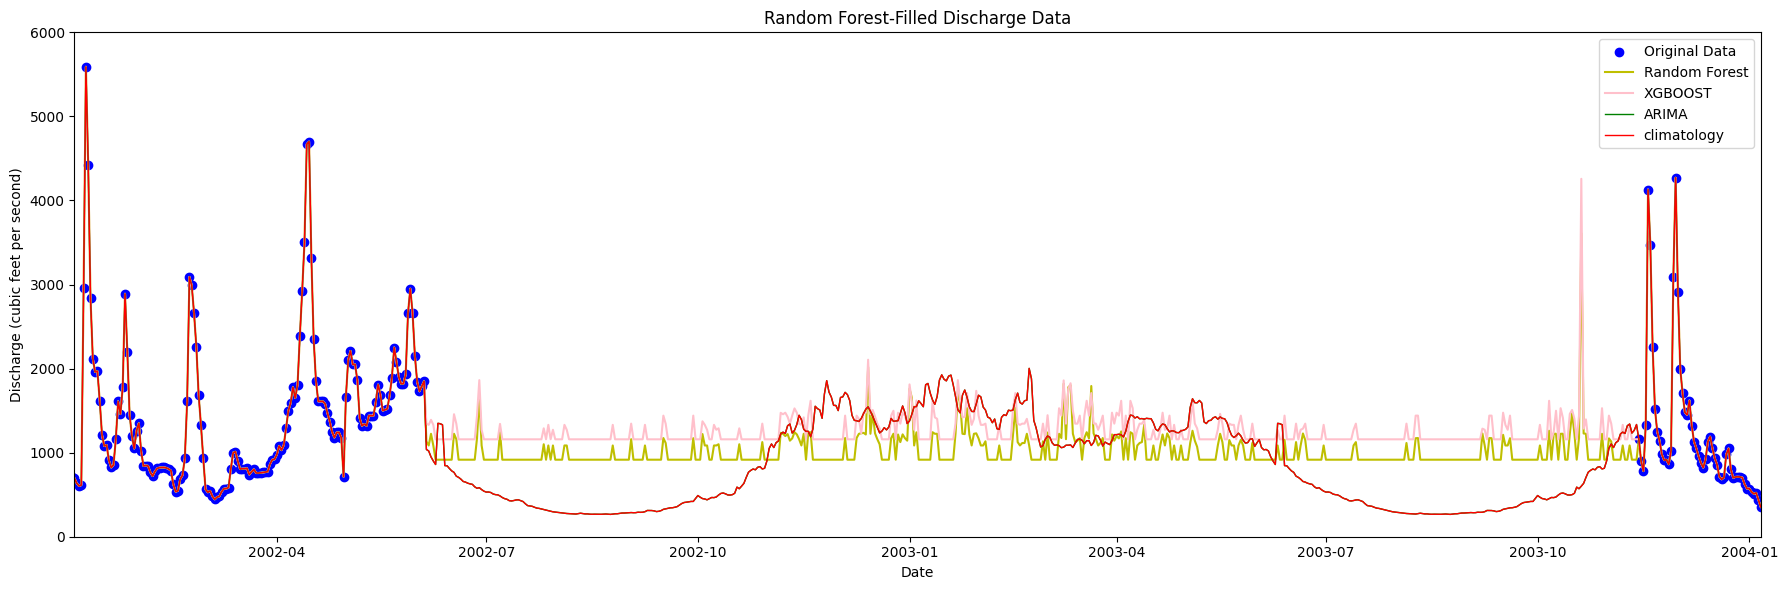

In [116]:
# Step 6: Visualize the result
plt.figure(figsize=(18, 6))

# Plot the original data (before filling gaps)
plt.scatter(nogaps, df1.loc[nogaps], color='b', label='Original Data')
plt.plot(df_rf.index, df_rf['discharge'], color='y', label='Random Forest')
plt.plot(df_xgb.index,df_xgb['discharge'],color='pink',label='XGBOOST')
plt.plot(dsx.index, dsx['discharge'], color='g', label='ARIMA', lw=1)
plt.plot(ds1.index, ds1.discharge, color='r', label='climatology', lw=1)

# Plot settings
plt.title('Random Forest-Filled Discharge Data')
plt.xlabel('Date')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.xlim(pd.to_datetime('2002-01-03'), pd.to_datetime('2004-01-06'))
plt.ylim(0, 6000)
#plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# prompt: BUILD THE LSTM MODEL SIMILAR TO RF AND OTHER MODELS ABOVE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# ... (Previous code remains the same)

# Step 1: Prepare the data for LSTM
# Scale the data
scaler = MinMaxScaler()
df_lstm = ds1.copy(deep=True)
df_lstm['prcp'] = df_precip.PRCP_filled_knn
df_lstm[['discharge', 'prcp']] = scaler.fit_transform(df_lstm[['discharge', 'prcp']])

# Create sequences for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Prepare the training data
train_data = df_lstm.loc[nogaps, ['discharge', 'prcp']].values
X_train, y_train = create_dataset(train_data, look_back=1)  # Adjust look_back as needed

# Prepare the test data
test_data = df_lstm.loc[gaps, ['prcp']].values
X_test = []
for i in range(len(test_data) - 1):
    a = test_data[i:(i+1), 0]
    X_test.append(a)
X_test = np.array(X_test)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 2: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Step 3: Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)  # Adjust epochs and batch size

# Step 4: Predict missing values
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(np.concatenate((predicted_values, test_data[:, 0].reshape(-1, 1)), axis=1))[:, 0]

# Step 5: Fill the gaps
df_lstm.loc[gaps, 'discharge'] = predicted_values

# Step 6: Visualize the result
plt.figure(figsize=(18, 6))
plt.scatter(nogaps, df1.loc[nogaps], color='b', label='Original Data')
plt.plot(df_lstm.index, df_lstm['discharge'], color='m', label='LSTM')
plt.title('LSTM-Filled Discharge Data')
plt.xlabel('Date')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: cannot reshape array of size 21812 into shape (21812,1,2)

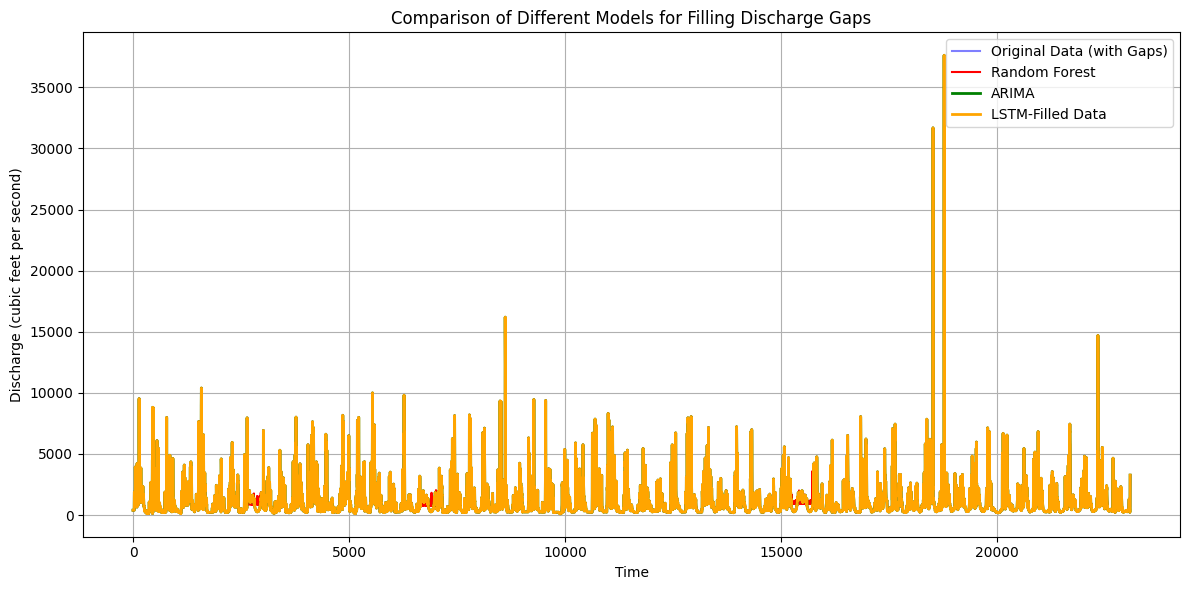

In [46]:
# prompt: build the last model as done previously here

# Assuming that RandomForestRegressor has been trained as 'best_rf_model'
importances = rf_model.feature_importances_  # Get feature importances from the model
feature_names = X_train.columns  # Feature names: 'time' and 'prcp'

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


# Step 1: Prepare the data (same preprocessing as RF model)
df_xgb = ds1.copy(deep=True)  # Copy of the data
df_xgb['prcp'] = df_precip.PRCP_filled_knn  # Precipitation filled with KNN
df_xgb['time'] = np.arange(len(df_xgb))  # Time feature

# Train data
train_data = df_xgb.loc[nogaps, ['time', 'discharge', 'prcp']]
test_data = df_xgb.loc[gaps, ['time', 'prcp']]

X_train = train_data[['time', 'prcp']]  # Features for training
y_train = train_data['discharge']  # Target variable

# Step 2: Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 3: Predict missing values
if len(test_data) > 0:
    predicted_values = xgb_model.predict(test_data[['time', 'prcp']])
    df_xgb.loc[gaps, 'discharge'] = predicted_values

# Step 4: Feature importance using SHAP and beeswarm plot
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

# Plot the SHAP values (beeswarm plot for feature importance)
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, show=False)
plt.title('XGBoost Feature Importance - SHAP Beeswarm Plot')
plt.tight_layout()
plt.show()

# Optional: Visualize the final result
plt.figure(figsize=(12, 6))
plt.scatter(nogaps, df1.loc[nogaps], color='b', label='Original Data')
plt.plot(df_xgb.index, df_xgb['discharge'], color='g', label='XGBoost-Filled Discharge Data')
plt.title('XGBoost-Filled Discharge Data')
plt.xlabel('Time')
plt.ylabel('Discharge (cubic feet per second)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [128]:
# prompt: calculate performene metrics of all these lagorthims

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate performance metrics for Random Forest
y_true_rf = df1.loc[gaps]
y_pred_rf = df_rf.loc[gaps, 'discharge']
mse_rf = mean_squared_error(y_true_rf, y_pred_rf)
rmse_rf = mean_squared_error(y_true_rf, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_true_rf, y_pred_rf)
r2_rf = r2_score(y_true_rf, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.2f}")
print(f"Random Forest - RMSE: {rmse_rf:.2f}")
print(f"Random Forest - MAE: {mae_rf:.2f}")
print(f"Random Forest - R-squared: {r2_rf:.2f}")

# Calculate performance metrics for XGBoost
y_true_xgb = df1.loc[gaps]
y_pred_xgb = df_xgb.loc[gaps, 'discharge']
mse_xgb = mean_squared_error(y_true_xgb, y_pred_xgb)
rmse_xgb = mean_squared_error(y_true_xgb, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_true_xgb, y_pred_xgb)
r2_xgb = r2_score(y_true_xgb, y_pred_xgb)

print(f"\nXGBoost - MSE: {mse_xgb:.2f}")
print(f"XGBoost - RMSE: {rmse_xgb:.2f}")
print(f"XGBoost - MAE: {mae_xgb:.2f}")
print(f"XGBoost - R-squared: {r2_xgb:.2f}")

# Calculate performance metrics for ARIMA
y_true_arima = df1.loc[gaps]
y_pred_arima = dsx.loc[gaps, 'discharge']
mse_arima = mean_squared_error(y_true_arima, y_pred_arima)
rmse_arima = mean_squared_error(y_true_arima, y_pred_arima, squared=False)
mae_arima = mean_absolute_error(y_true_arima, y_pred_arima)
r2_arima = r2_score(y_true_arima, y_pred_arima)

print(f"\nARIMA - MSE: {mse_arima:.2f}")
print(f"ARIMA - RMSE: {rmse_arima:.2f}")
print(f"ARIMA - MAE: {mae_arima:.2f}")
print(f"ARIMA - R-squared: {r2_arima:.2f}")

# Calculate performance metrics for SARIMAX
y_true_sarimax = df1.loc[gaps]
y_pred_sarimax = df_sarimax.loc[gaps, 'discharge']
mse_sarimax = mean_squared_error(y_true_sarimax, y_pred_sarimax)
rmse_sarimax = mean_squared_error(y_true_sarimax, y_pred_sarimax, squared=False)
mae_sarimax = mean_absolute_error(y_true_sarimax, y_pred_sarimax)
r2_sarimax = r2_score(y_true_sarimax, y_pred_sarimax)

print(f"\nSARIMAX - MSE: {mse_sarimax:.2f}")
print(f"SARIMAX - RMSE: {rmse_sarimax:.2f}")
print(f"SARIMAX - MAE: {mae_sarimax:.2f}")
print(f"SARIMAX - R-squared: {r2_sarimax:.2f}")

# Calculate performance metrics for LSTM
y_true_lstm = df1.loc[gaps]
y_pred_lstm = df_lstm.loc[gaps, 'discharge']
mse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)
rmse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm, squared=False)
mae_lstm = mean_absolute_error(y_true_lstm, y_pred_lstm)
r2_lstm = r2_score(y_true_lstm, y_pred_lstm)

print(f"\nLSTM - MSE: {mse_lstm:.2f}")
print(f"LSTM - RMSE: {rmse_lstm:.2f}")
print(f"LSTM - MAE: {mae_lstm:.2f}")
print(f"LSTM - R-squared: {r2_lstm:.2f}")


KeyError: "None of [DatetimeIndex(['1968-01-04', '1968-01-05', '1968-01-06', '1968-01-07',\n               '1968-01-08', '1968-01-09', '1968-01-10', '1968-01-11',\n               '1968-01-12', '1968-01-13',\n               ...\n               '2003-11-04', '2003-11-05', '2003-11-06', '2003-11-07',\n               '2003-11-08', '2003-11-09', '2003-11-10', '2003-11-11',\n               '2003-11-12', '2003-11-13'],\n              dtype='datetime64[ns]', length=1261, freq=None)] are in the [index]"